# Prediction of United States' Counties Poverty Rates
Mark Vervuurt <br>
19-01-2018

## Executive Summary

This document presents the results of the regression analysis to predict poverty rates of United States' Counties. The result of this regression analysis is the creation of an AdaBoostRegressor. This AdaBoostRegressor is able to predict United States' Counties poverty rates with an RMSE of 2.7853. 

In the data understanding phase was discovered that the following features play a significant role in predicting United States' counties poverty rates. They have moderate positive and negative Pearson correlation coefficients. Furthermore the Boxplots show enough variation and separation of the data with respect to the target variable poverty_rate. However recursive function elimination was ultimately used to select the optimum number of features for the lowest RMSE score.

| Significant Features                                | Short Description
|:----------------------------------------------------|:---------
| area__rucc                                          | Rural urban continuum code of county
| econ__economic_typology                             | economic dependence type of county
| aui_pct65y_cat                                      | created categorical feature combining area__urban_influence and categorical percentage of 65 years old per county
| demo__pct_adults_less_than_a_high_school_diploma    | percentage of adults with less than high school diploma per county
| health__homicides_per_100k                          | homicides per 100k inhabitants per county
| econ__pct_unemployment                              | percentage of unemployment per county
| health__pct_low_birthweight                         | percentage of low birth weight per county
| econ__pct_uninsured_adults                          | percentage of uninsured adults per county
| health__pct_diabetes                                | percentage of diabetes per county
| demo__pct_non_hispanic_african_american             | percentage of African Americans per county
| econ__pct_civilian_labor                            | percentage of civilian labor per county

The CRISP-DM Methodology was used in order to create an accurate regression model:

- __Business Understanding__: read through the '[Rural Poverty & Well-being](https://www.ers.usda.gov/topics/rural-economy-population/rural-poverty-well-being/poverty-overview.aspx)' report to better understand the circumstances of poverty.
- __Data Understanding__: explore the quantitative and categorical variables that play a key role in predicting poverty rates. Create new, better and informative features.
- __Data Preparation__: drop redundant and uninformative features, fill missing values, etc.
- __Modeling__: create and select the best regression model.
- __Evaluation__: evaluate the regression models using nested cross validation.
- __Deployment__: the deployment of the regression model is not strictly applicable here. However presenting the results of the regression analysis with this report can be considered as the deployment step.

## Business Understanding
As described in the online report the '[Rural Poverty & Well-being](https://www.ers.usda.gov/topics/rural-economy-population/rural-poverty-well-being/poverty-overview.aspx)': "Concentrated poverty contributes to poor housing and health conditions, higher crime and school dropout rates, as well as employment dislocations". With this information the data will be explored to see how health, crime,education and employment related factors contribute to poverty.

Another important feature of poverty is time. An area that doesn't have a high level of poverty in two following years is likely better off than an area that has a high level of poverty in both years. It will not be possible to construct a feature with this information because we cannot compare the state's poverty rate over year 'a' and 'b' within this data set. We don't have a unique key to identify counties.

Counties are generally compared by their Non-Metro and Metro status. There is more poverty in Non-Metro areas than Metro areas. Poverty is also higher under certain ages and ethnicities. Here also the data will be explored on the basis of this information.

In [2]:
import re
import bs4
import time
import plyfile
import html5lib
import multiprocessing
import itertools

import numpy as np
import pandas as pd

import seaborn as sns
from scipy import misc
import scipy.io.wavfile as wavfile

import scipy
from math import sqrt
from scipy import stats
from pprint import pprint
from sklearn import tree
from sklearn.svm import SVC
from sklearn import manifold
from tempfile import mkdtemp
from textwrap import wrap
from matplotlib import cm as cm

import sklearn.metrics as metrics
from pandas.plotting import scatter_matrix
from scipy.stats import randint as sp_randint
from sklearn.pipeline import TransformerMixin
from sklearn.metrics.scorer import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Binarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV, SelectFromModel, f_regression, SelectKBest
from sklearn.ensemble import RandomForestClassifier, AdaBoostRegressor, AdaBoostClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, RobustScaler, StandardScaler
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate, cross_val_predict, KFold, ShuffleSplit, StratifiedShuffleSplit

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import parallel_coordinates, andrews_curves

%matplotlib inline
matplotlib.style.use('ggplot')

pd.set_option('display.max_columns', None)

## Data Understanding
In order to build this regression model and determine its most significant features a thorough data exploration was done to understand the relationship between poverty rates and other features.
### Initial Data Exploration
The dataset consists of 3198 records about United States' counties. Each record contains socioeconomic indicators about a United States' county for a given year. Besides the 'row_id', 'yr' and the target value 'poverty_rate', the dataset contains 32 features about socioeconomic indicators.

In [3]:
poverty_train = pd.read_csv('./Microsoft_-_DAT102x_Predicting_Poverty_in_the_United_States_-_Training_values.csv')

In [4]:
train_shape_tmp = poverty_train.shape

In [5]:
train_dytpes_tmp = poverty_train.dtypes

#### Individual Feature Statistics
Here are the summary statistics for all the socioeconomic features:
- summary statistics of categorical variables: the total count (count), number of unique elements (unique), most frequent element (top) and the frequency of the most frequent element (frequent)
- summary statistics of quantitative variables: the mean, the standard deviation (std), the minimum value (min), 25% percentile, 50% percentile (median), 75% percentile and the maximum value (max).

In [6]:
poverty_train.drop(columns=['row_id'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
econ__pct_civilian_labor,3198.0,0.467071,0.074541,0.217000,0.420000,0.467000,0.514000,1.000000
econ__pct_unemployment,3198.0,0.059610,0.022850,0.008000,0.044000,0.057000,0.071000,0.240000
econ__pct_uninsured_adults,3196.0,0.217534,0.067372,0.046000,0.166000,0.216000,0.262000,0.495000
econ__pct_uninsured_children,3196.0,0.085920,0.040005,0.009000,0.057000,0.077000,0.105000,0.285000
demo__pct_female,3196.0,0.498781,0.024251,0.294000,0.493000,0.503000,0.512000,0.576000
demo__pct_below_18_years_of_age,3196.0,0.227763,0.034291,0.098000,0.207000,0.226000,0.245250,0.417000
demo__pct_aged_65_years_and_older,3196.0,0.170137,0.043594,0.043000,0.142000,0.167000,0.194000,0.355000
demo__pct_hispanic,3196.0,0.090233,0.142707,0.000000,0.019000,0.035000,0.088000,0.945000
demo__pct_non_hispanic_african_american,3196.0,0.091117,0.147104,0.000000,0.006000,0.022000,0.096250,0.855000
demo__pct_non_hispanic_white,3196.0,0.770207,0.207903,0.060000,0.648000,0.854000,0.936000,0.998000


In [7]:
poverty_labels = pd.read_csv('Microsoft_-_DAT102x_Predicting_Poverty_in_the_United_States_-_Training_labels.csv')

In [8]:
lbl_shape_tmp = poverty_labels.shape

In [9]:
lbl_dtype_tmp = poverty_labels.dtypes

Here are the summary statistics for the target variable which is quantitative:

In [10]:
poverty_labels.drop(columns=['row_id'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
poverty_rate,3198.0,16.817136,6.697969,2.5,12.0,15.8,20.3,47.4


Poverty rates are right or positively skewed with a skew value of 1.048357. We can recognize a slight bell curve in the data. The mean and median are relatively close to each other and the standard deviation is relatively low which indicates low variability in the poverty rates. Most United States' counties have a poverty_rate between 10% and 20% poverty.

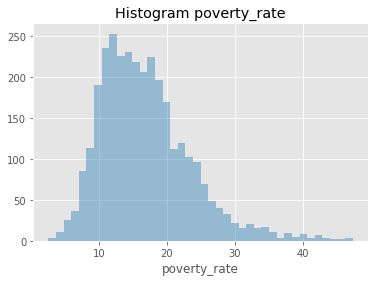

In [11]:
ht_pov = sns.distplot(poverty_labels.drop(columns=['row_id'], axis=1), kde=False, norm_hist=False, color='#1f77b4', axlabel='poverty_rate').set_title('Histogram poverty_rate')

In [12]:
poverty = pd.merge(poverty_train, poverty_labels, on='row_id')
pov_shape_tmp = poverty.shape

From the summary statistics above, should be clear that there are three categorical variables included in the dataset:
- area__rucc with 9 values: 
 - 'Nonmetro - Urban population of 2,500 to 19,999, adjacent to a metro area' counties are most frequent with 608 counties.
 - 'Nonmetro - Urban population of 20,000 or more, not adjacent to a metro area' counties are most infrequent with 100 counties.
- area__urban_influence	with 12 values: 
 - 'Small-in a metro area with fewer than 1 million residents' counties are most frequent with 692 counties.
 - 'Noncore not adjacent to a metro/micro area and contains a town of 2,500  or more residents' counties are most infrequent with 122.
- econ__economic_typology with 6 values: 
 - 'Non specialized' economic typology counties are most frequent with 1266 counties. 
 - 'Mining-dependent' economic typology counties are most infrequent with 254 counties.

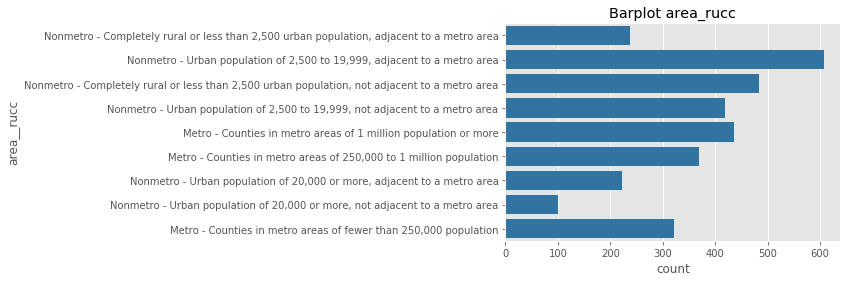

In [13]:
bh_ar = sns.countplot(y='area__rucc', data=poverty, color='#1f77b4').set_title("Barplot area_rucc")

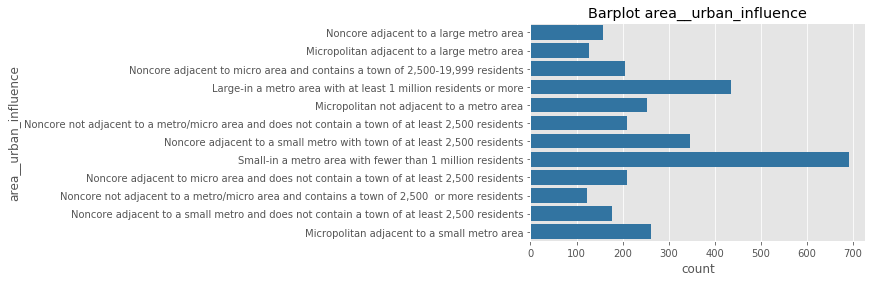

In [14]:
bh_aui = sns.countplot(y='area__urban_influence', data=poverty, color='#1f77b4').set_title("Barplot area__urban_influence")

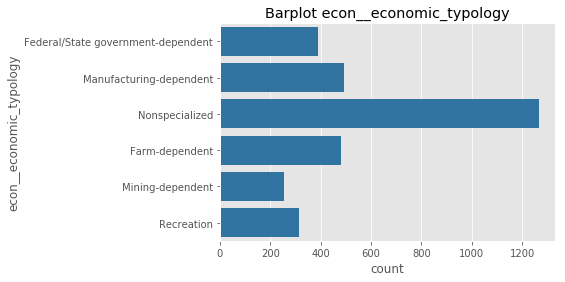

In [15]:
bh_eet = sns.countplot(y='econ__economic_typology', data=poverty, color='#1f77b4').set_title("Barplot econ__economic_typology")

### Data Exploration and Visualization of Categorical Variables
Here the predictive value of the categorical variables 'econ\_\_economic\_typology', 'area\_\_urban\_influence', 'area\_\_rucc' and 'yr' is explored. Box plots are used to explore these categorical variables.

The boxplots of the categorical variables "econ__economic_typology", "area__urban_influence" and "area__rucc" show interesting variation:
* 'Farm-dependent' counties have the lowest poverty rates and 'Federal/State government-dependent' counties have the highest poverty rates.
* 'Large-in a metro area with at least 1 million residents or more' counties have the lowest poverty rates.
* 'Metro - Counties in metro areas with 1 million population or more' counties have the lowest poverty rates.

Furthermore by combining features more interesting categorical variables can be created explaining much more of the variance in poverty rates.
* "demo__pct_aged_65_years_and_older" and "area__urban_influence". The general trend is that counties with a low percentage population of "65 years or older" have a higher poverty rate.

The difference in poverty over year 'a' and 'b' is really minimal. Furthermore it doesn't make sense to use this feature to predict poverty rates. This feature will be dropped at the cleaning stage.

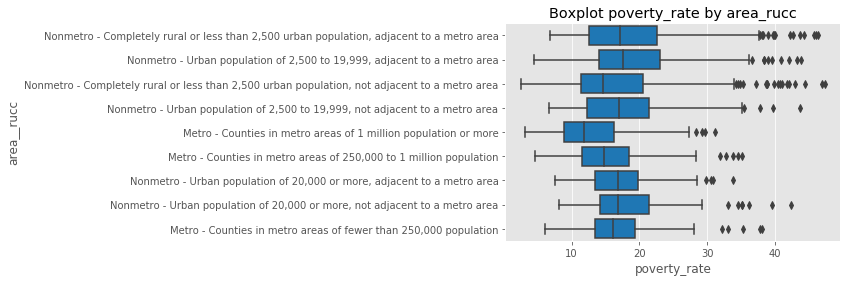

In [16]:
bpd_ar = sns.boxplot(orient="h", x='poverty_rate', y='area__rucc', data=poverty, color='#1f77b4', saturation=1.0).set_title('Boxplot poverty_rate by area_rucc')

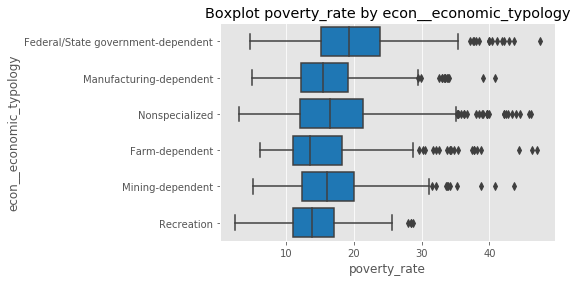

In [17]:
bpd_eet = sns.boxplot(orient="h", x='poverty_rate', y='econ__economic_typology', data=poverty, color='#1f77b4', saturation=1.0).set_title('Boxplot poverty_rate by econ__economic_typology')

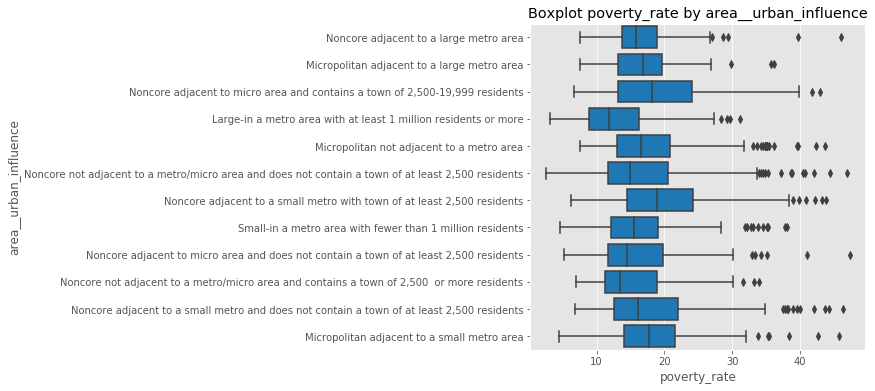

In [18]:
plt.figure(figsize=(6,6))
bpd_aui = sns.boxplot(orient="h", x='poverty_rate', y='area__urban_influence', data=poverty, color='#1f77b4', saturation=1.0).set_title('Boxplot poverty_rate by area__urban_influence')

In [19]:
def create_old_age_cat(input_df):
    low_pct_olds = poverty.demo__pct_aged_65_years_and_older < 0.167000
    high_pct_olds = poverty.demo__pct_aged_65_years_and_older >= 0.167000
    input_df.loc[low_pct_olds,'pct_65years_cat'] = 'low_pct_65years'
    input_df.loc[high_pct_olds,'pct_65years_cat'] = 'high_pct_65years'
    
    age_old_cats = ['low_pct_65years','high_pct_65years']
    input_df.loc[:,'pct_65years_cat'] = input_df.pct_65years_cat.astype('category')
    input_df.loc[:,'pct_65years_cat'] = input_df.pct_65years_cat.cat.set_categories(age_old_cats, ordered=True)
    return input_df

In [20]:
poverty = create_old_age_cat(poverty)

In [21]:
def create_aui_pct65y_cat(input_df):
    aui_cats = input_df.area__urban_influence.unique()
    pct65y_cats = input_df.pct_65years_cat.cat.categories
    
    aui_pct65y_masks = [ ((input_df.area__urban_influence == aui) & (input_df.pct_65years_cat == pct65y)
                          , aui + ', ' + pct65y) 
                        for (aui, pct65y) in list(itertools.product(aui_cats, pct65y_cats))]

    aui_pct65y_lbls = [aui + ', ' + pct65y for (aui, pct65y)  
                    in list(itertools.product(aui_cats, pct65y_cats))]
      
    for mask, aui_pct65y_lb in aui_pct65y_masks:
        input_df.loc[mask, 'aui_pct65y_cat'] = aui_pct65y_lb
        
    input_df.loc[:,'aui_pct65y_cat'] = input_df.aui_pct65y_cat.astype('category')
    input_df.loc[:,'aui_pct65y_cat'] = input_df.aui_pct65y_cat.cat.set_categories(aui_pct65y_lbls)
    return input_df

In [22]:
poverty = create_aui_pct65y_cat(poverty)

### Data Exploration and Visualization of Quantitative Variables
For the quantitative variables the correlation matrix is computed first followed by the visual display of the scatter plot matrices.

#### Correlation Matrix
The strongest correlations observed are moderate positive and negative for the following features:
- demo__pct_adults_less_than_a_high_school_diploma    
- health__homicides_per_100k                          
- econ__pct_unemployment                              
- health__pct_low_birthweight                         
- econ__pct_uninsured_adults                          
- health__pct_diabetes                                
- demo__pct_non_hispanic_african_american             
- econ__pct_civilian_labor    
- demo__pct_non_hispanic_white
- demo__pct_adults_bachelors_or_higher

The whole correlation matrix of interest is shown here under.

| Features                                            | Pearson Correlation Coefficient
|:----------------------------------------------------|---------
| econ__pct_civilian_labor                            | -0.670417
| demo__pct_non_hispanic_white                        | -0.499974
| demo__pct_adults_bachelors_or_higher                | -0.467134
| demo__pct_adults_with_some_college                  | -0.363875
| health__pct_excessive_drinking                      | -0.353254
| demo__pct_asian                                     | -0.163033
| demo__pct_aged_65_years_and_older                   | -0.088123
| demo__pct_female                                    | -0.068065
| demo__pct_below_18_years_of_age                     |  0.039237
| health__air_pollution_particulate_matter            |  0.058582
| econ__pct_uninsured_children                        |  0.098882
| demo__pct_hispanic                                  |  0.105574
| demo__birth_rate_per_1k                             |  0.127506
| health__pop_per_primary_care_physician              |  0.156942
| demo__pct_adults_with_high_school_diploma           |  0.202928
| demo__pct_american_indian_or_alaskan_native         |  0.236508
| demo__death_rate_per_1k                             |  0.244093
| health__pop_per_dentist                             |  0.268996
| health__pct_adult_smoking                           |  0.395457
| health__motor_vehicle_crash_deaths_per_100k         |  0.420348
| health__pct_physical_inacticity                     |  0.437680
| health__pct_adult_obesity                           |  0.444293
| demo__pct_non_hispanic_african_american             |  0.507048
| health__pct_diabetes                                |  0.537038
| econ__pct_uninsured_adults                          |  0.541712
| health__pct_low_birthweight                         |  0.565456
| econ__pct_unemployment                              |  0.592022
| health__homicides_per_100k                          |  0.621399
| demo__pct_adults_less_than_a_high_school_diploma    |  0.680360

#### Scatter Plot Matrices
After reading the '[Rural Poverty & Well-being](https://www.ers.usda.gov/topics/rural-economy-population/rural-poverty-well-being/poverty-overview.aspx)' report it is clear that education, ethnicity and health related issues play an important role in predicting poverty. In this dataset are also added economic indicators of United States' counties. The scatter plot matrices of these four groups of socioeconomic indicators are shown here under. The scatter plot matrices visually confirms the finding of the correlation matrix.

NB: linear statistical transformations (sqrt, square, exponential, etc) were also applied to the target variable 'poverty_rate' but they did not improve substantially the correlation coefficients and the scatter plot matrices.

The correlation matrices and scatter plot matrices visually confirm that the variables correlate moderately strong with the target variable 'poverty_rate' seem to have a linear relationship.

--> limit to most important or special scatterplot matrices

##### Moderately Strong Correlating Features Scatter Plot Matrices

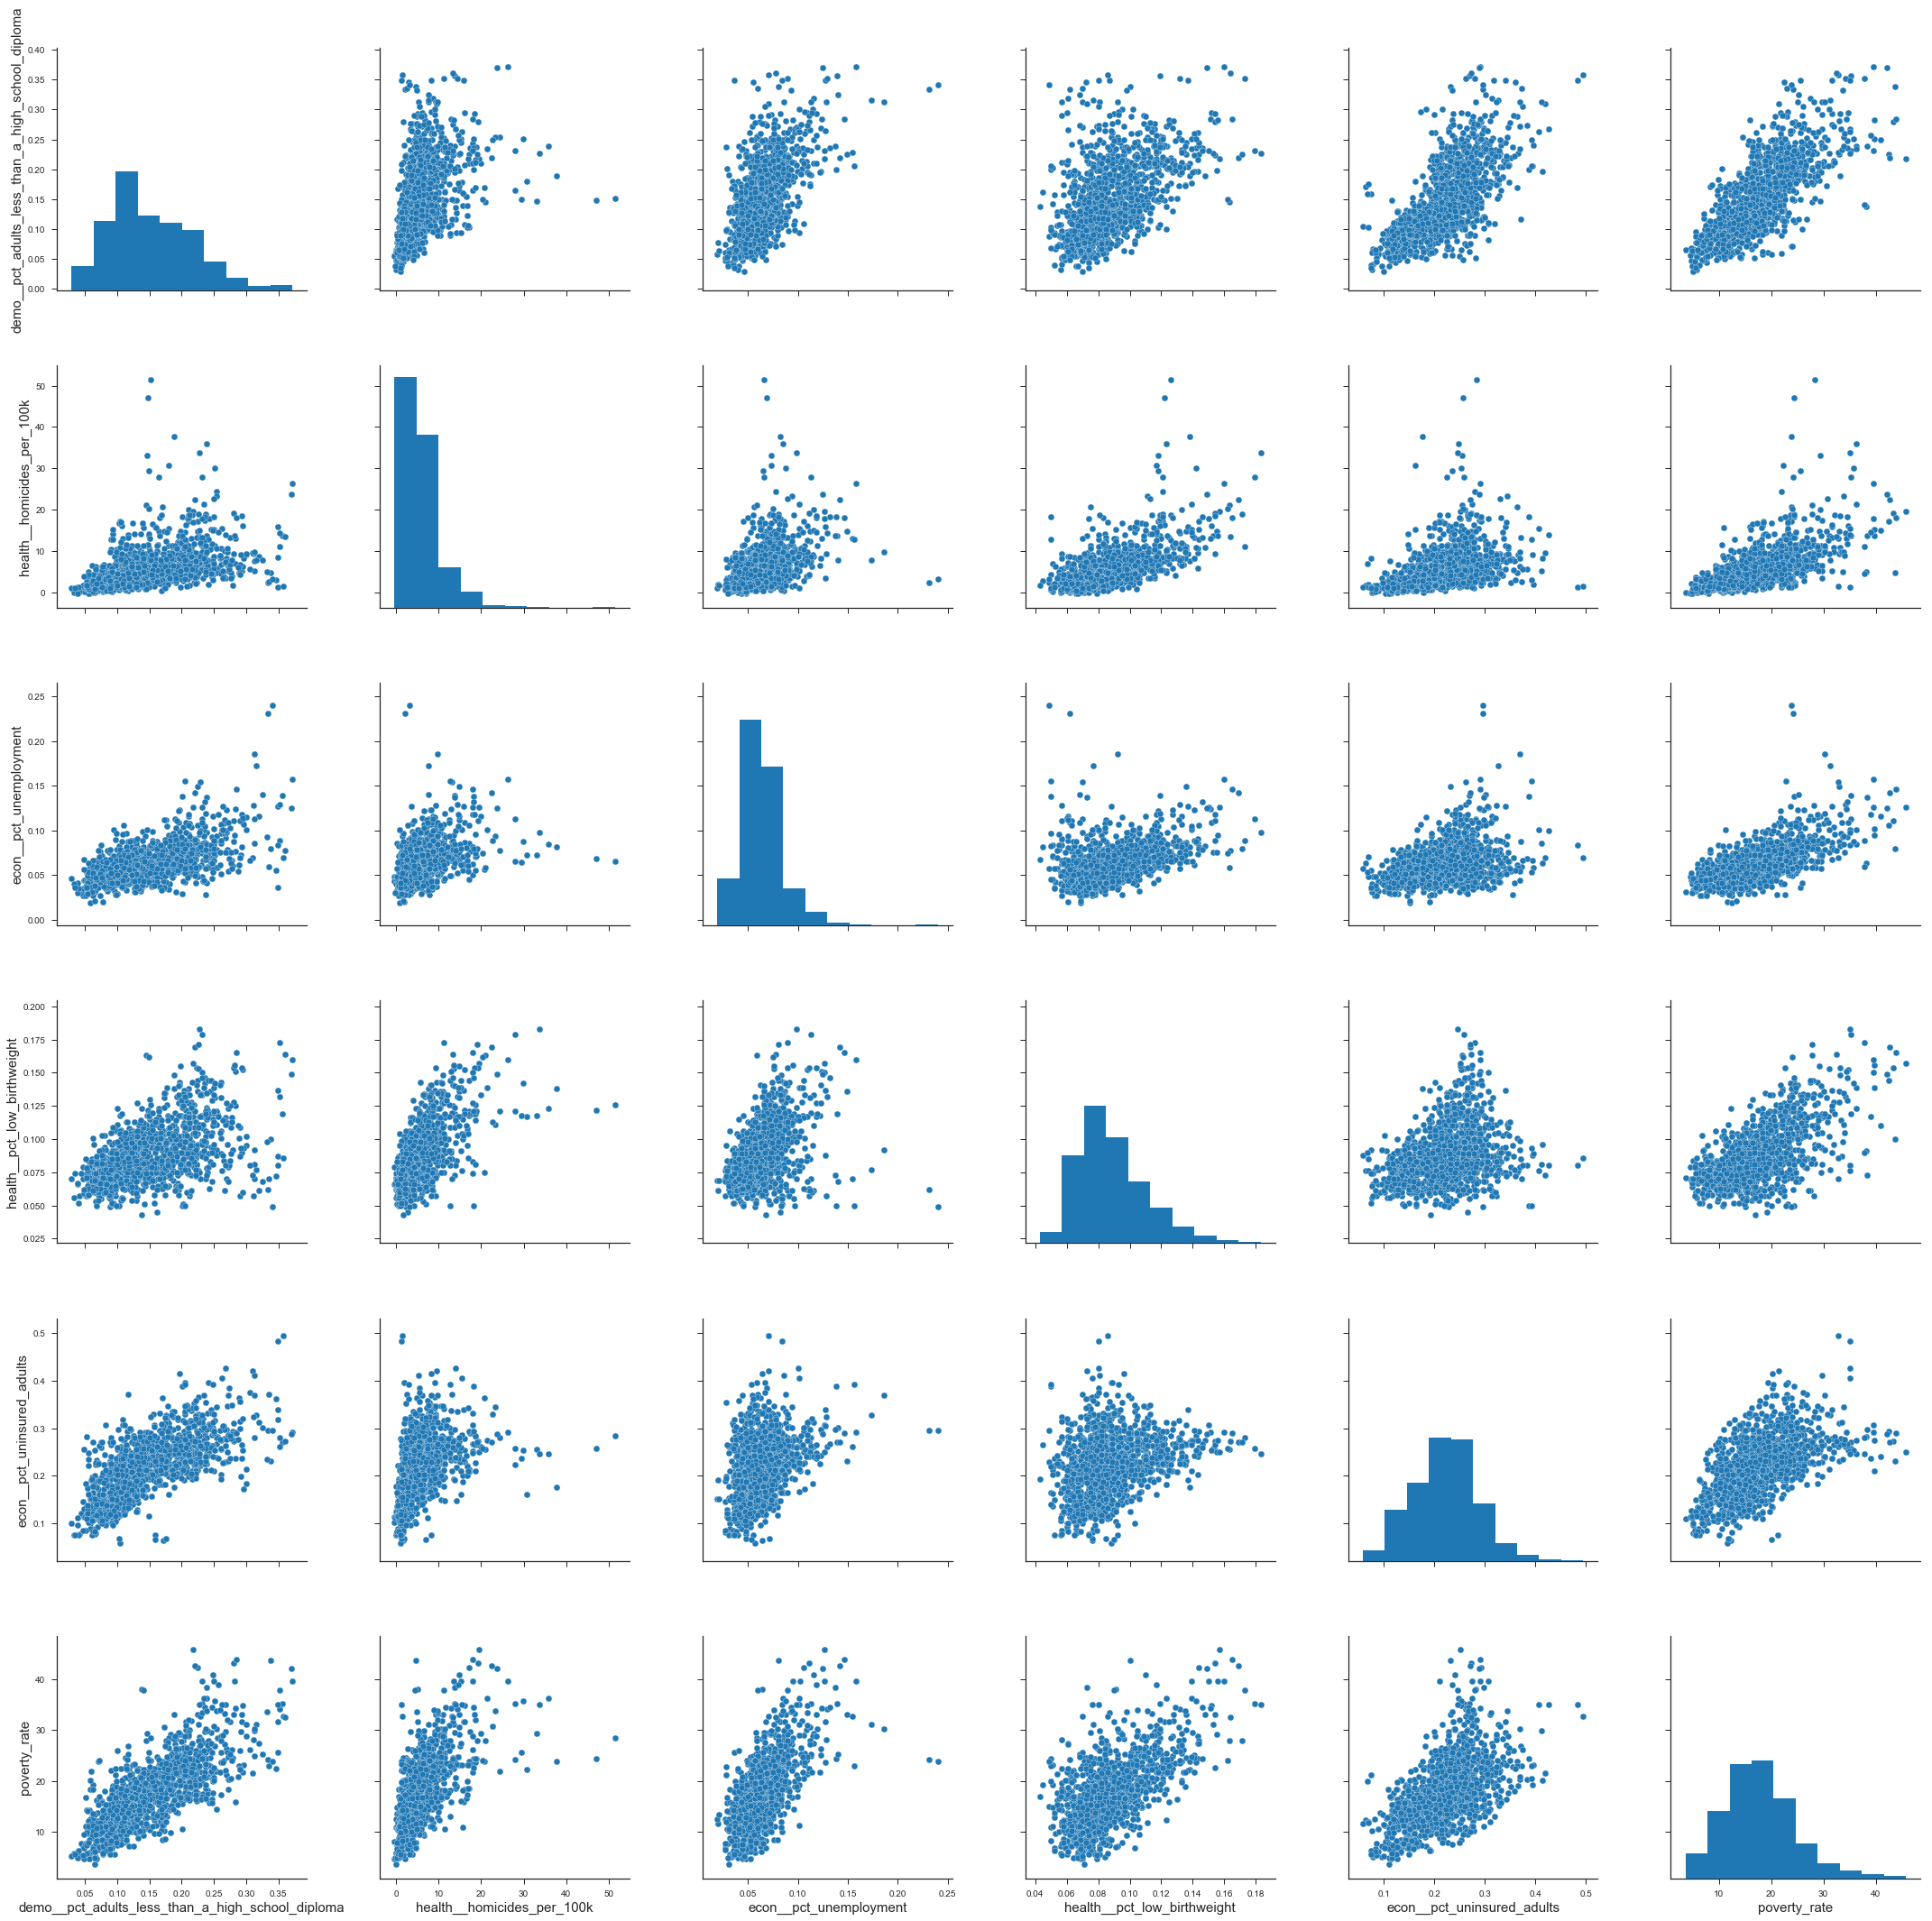

In [23]:
sns.set(style="ticks")
plt.rcParams["axes.labelsize"] = 15
scatter_top = sns.pairplot(poverty.loc[:, ['demo__pct_adults_less_than_a_high_school_diploma'
                                              ,'health__homicides_per_100k','econ__pct_unemployment'
                                              ,'health__pct_low_birthweight','econ__pct_uninsured_adults'
                                              ,'poverty_rate']].dropna(), size=5
                           , plot_kws={'color': '#1f77b4'}, diag_kws={'color': '#1f77b4'})

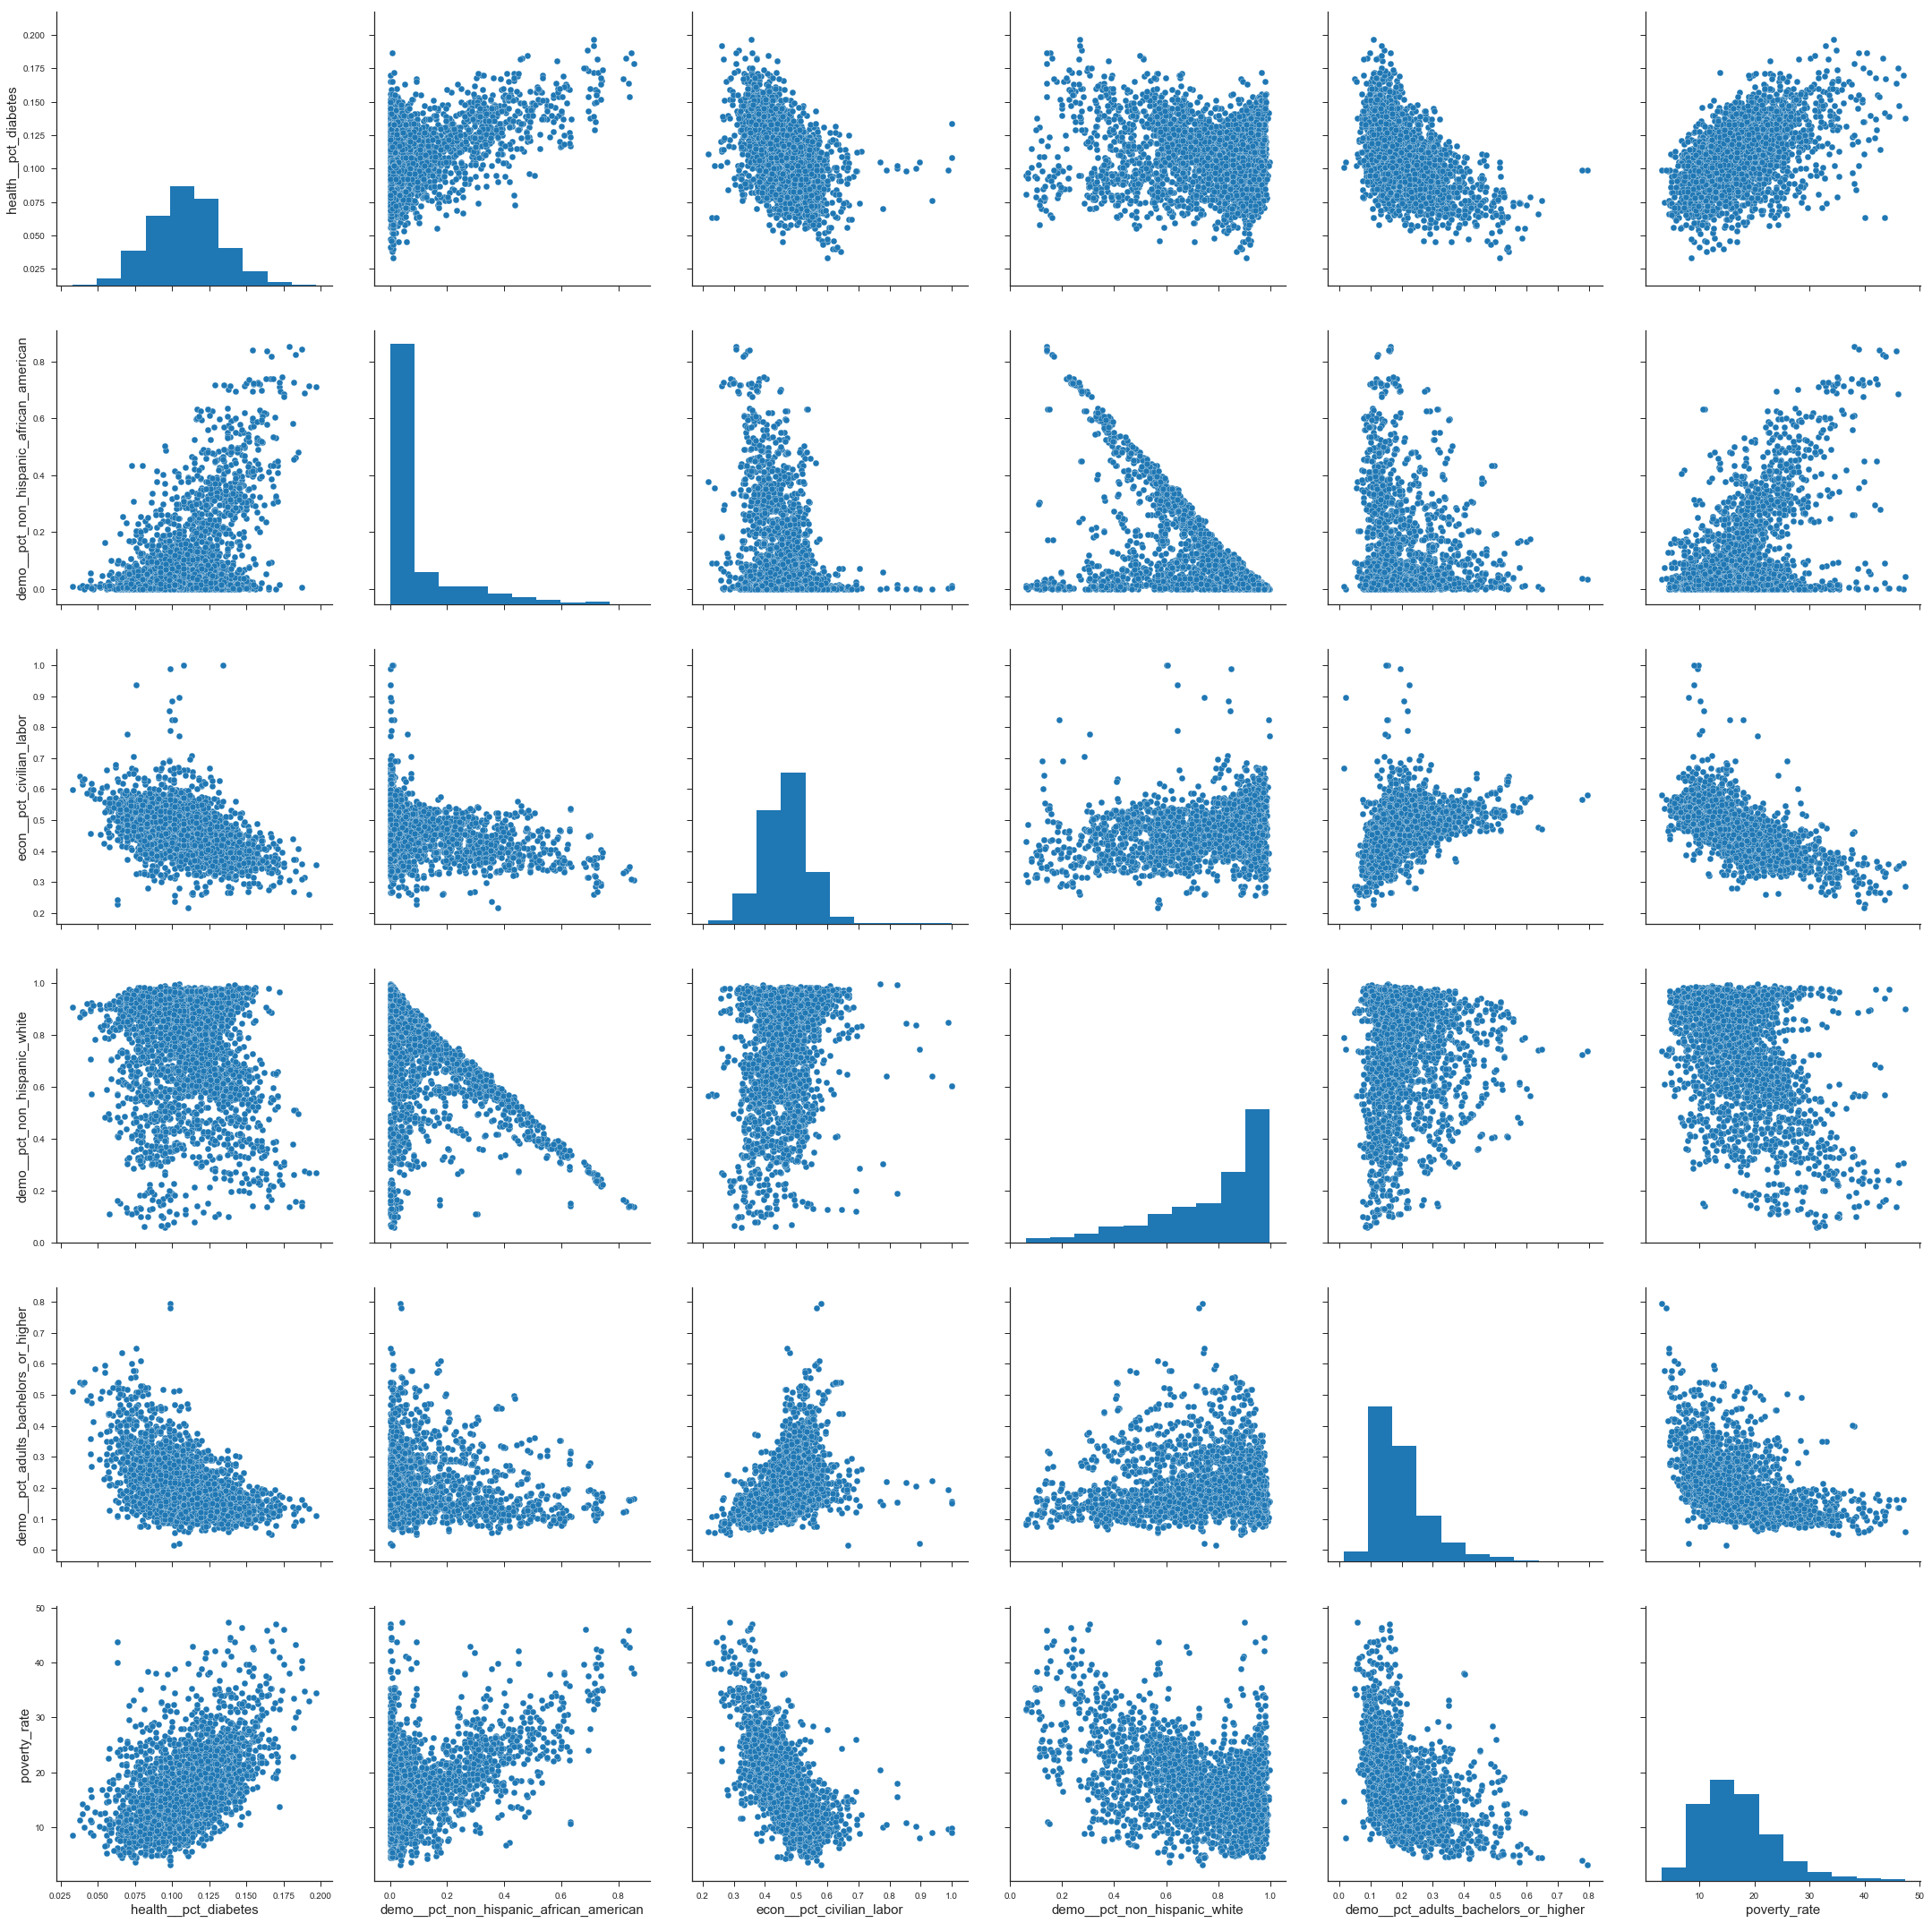

In [24]:
plt.rcParams["axes.labelsize"] = 15
scatter_top = sns.pairplot(poverty.loc[:, [ 'health__pct_diabetes', 'demo__pct_non_hispanic_african_american'
                                            ,'econ__pct_civilian_labor','demo__pct_non_hispanic_white'
                                               ,'demo__pct_adults_bachelors_or_higher'
                                              ,'poverty_rate']].dropna(), size=5
                           , plot_kws={'color': '#1f77b4'}, diag_kws={'color': '#1f77b4'})

##### Categorical Features Scatter Plot Matrices

These quantitative features behave like categorical features. 

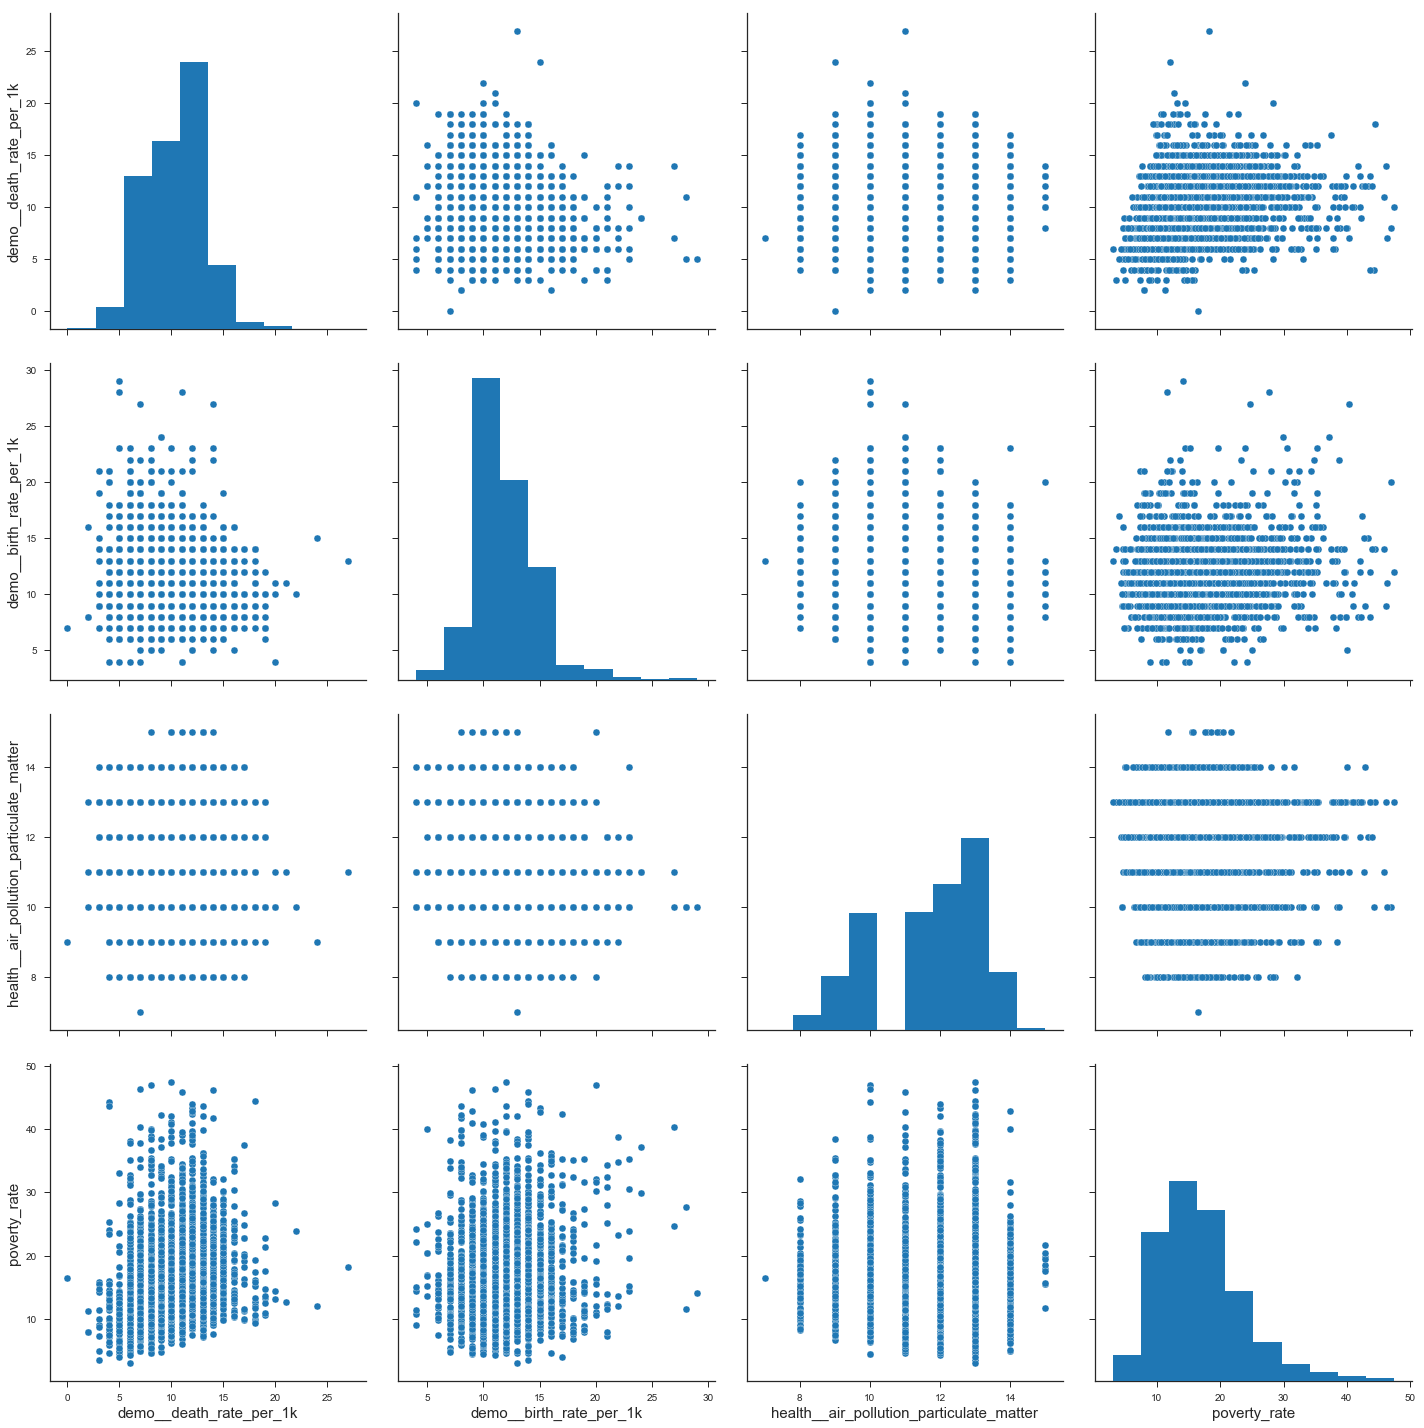

In [25]:
scatter_non_ln = sns.pairplot(poverty.loc[:, ['demo__death_rate_per_1k'
                                              ,'demo__birth_rate_per_1k'
                                              ,'health__air_pollution_particulate_matter'
                                              ,'poverty_rate']].dropna(), size=5
                             , plot_kws={'color': '#1f77b4'}, diag_kws={'color': '#1f77b4'})

#### Creation and Visualization of New Categorical Variables
From observing the scatter plot matrices of the features 'demo\_\_death\_rate\_per\_1k', 'demo\_\_birth\_rate\_per\_1k' and 'health\_\_air\_pollution\_particulate\_matter' is clear that these quantitative variables behave like categorical variables. They will be transformed into categorical features by binning them.

In [26]:
def create_birthrate_cat(input_df):
    cats = [ "birthrate {0} - {1}".format(i, i + 5) for i in range(0, 40, 5) ]
    input_df.loc[:,'birth_rate_cat'] = pd.cut(input_df.demo__birth_rate_per_1k, range(0, 45, 5), right=False, include_lowest=True, labels=cats)
    input_df.loc[:,'birth_rate_cat'] = input_df.birth_rate_cat.astype('category')
    input_df.loc[:,'birth_rate_cat'] = input_df.birth_rate_cat.cat.set_categories(cats, ordered=True)
    return input_df

In [27]:
def create_deathrate_cat(input_df):
    cats = [ "deathrate {0} - {1}".format(i, i + 5) for i in range(0, 40, 5) ]
    input_df.loc[:,'death_rate_cat'] = pd.cut(input_df.demo__death_rate_per_1k, range(0, 45, 5), right=False, include_lowest=True, labels=cats)
    input_df.loc[:,'death_rate_cat'] = input_df.death_rate_cat.astype('category')
    input_df.loc[:,'death_rate_cat'] = input_df.death_rate_cat.cat.set_categories(cats, ordered=True)
    return input_df

In [28]:
def create_air_poll_cat(input_df):
    cats = [ "airpoll {0} - {1}".format(i, i + 5) for i in range(0, 35, 5) ]
    input_df.loc[:,'air_poll_cat'] = pd.cut(input_df.health__air_pollution_particulate_matter, range(0, 40, 5), right=False, include_lowest=True, labels=cats)
    input_df.loc[:,'air_poll_cat'] = input_df.air_poll_cat.astype('category')
    input_df.loc[:,'air_poll_cat'] = input_df.air_poll_cat.cat.set_categories(cats, ordered=True)
    return input_df

In [29]:
def create_features(input_df):
    input_df = create_birthrate_cat(input_df)
    input_df = create_deathrate_cat(input_df)
    input_df = create_air_poll_cat(input_df)
    return input_df

In [30]:
poverty = create_features(poverty)

## Data Preparation
This phase involves mostly the cleaning, scaling and one hot encoding of features:
* dropping redundant features
* converting features to the right type
* missing values are replaced by the respective median value of the feature. The median is preferred over the mean because it is less sensible to skewed data and gives a better measure of centrality.
* features are scaled to have the same scale. The MinMaxScaler is applied to the features "health__homicides_per_100k' and 'health__motor_vehicle_crash_deaths_per_100k' to scale them the same way as other quantitative variables that are in percentages between 0 and 1.
* One hot encoding of the categorical variables is performed

In [31]:
def drop_features(input_df):
    result_df = input_df.drop(columns=['health__air_pollution_particulate_matter'
                                      ,'demo__death_rate_per_1k', 'demo__birth_rate_per_1k'
                                      ,'pct_65years_cat','aui_pct65y_cat','yr'], axis=1)
    return result_df

In [32]:
poverty_clean = drop_features(poverty)

In [33]:
def convert_to_cat(input_df):
    input_df.loc[:,'area__rucc'] = input_df.area__rucc.astype("category")
    input_df.loc[:,'area__urban_influence'] = input_df.area__urban_influence.astype("category")
    input_df.loc[:,'econ__economic_typology'] = input_df.econ__economic_typology.astype("category")
    return input_df

In [34]:
poverty_clean = convert_to_cat(poverty_clean)

In [35]:
dtypes_tmp = poverty_clean.dtypes

In [36]:
def clean_nans(input_df):
    result_df = input_df.fillna(poverty_clean.median())
    return result_df

In [37]:
poverty_clean = clean_nans(poverty_clean)

In [38]:
clean_tmp = poverty_clean.isnull().sum()

In [39]:
def scale_features(input_df):
    input_scale = input_df.loc[:,['health__homicides_per_100k'
                                    ,'health__motor_vehicle_crash_deaths_per_100k'
                                 ,'health__pop_per_dentist'
                                 ,'health__pop_per_primary_care_physician']]
    
    input_scaled = pd.DataFrame(MinMaxScaler().fit_transform(input_scale), columns=input_scale.columns)
    
    input_df.loc[:,'health__homicides_per_100k'] = input_scaled.loc[:,'health__homicides_per_100k']
    input_df.loc[:,'health__motor_vehicle_crash_deaths_per_100k'] = input_scaled.loc[:,'health__motor_vehicle_crash_deaths_per_100k']
    input_df.loc[:,'health__pop_per_dentist'] = input_scaled.loc[:,'health__pop_per_dentist']
    input_df.loc[:,'health__pop_per_primary_care_physician'] = input_scaled.loc[:,'health__pop_per_primary_care_physician']
    return input_df

In [40]:
poverty_clean = scale_features(poverty_clean)

In [41]:
def cat_to_dummies(input_df):
    result_df = pd.get_dummies(input_df, dummy_na=True, columns=['area__rucc','econ__economic_typology'
                                                                ,'birth_rate_cat','death_rate_cat','air_poll_cat'
                                                                ,'area__urban_influence'])
    return result_df

In [42]:
poverty_clean = cat_to_dummies(poverty_clean)

In [43]:
shape_tmp = poverty_clean.shape

## Modeling and Evaluation
In this phase two models are compared with each other using the RMSE evaluation metric:
* Least Square Linear Model after applying recursive feature selection to create a linear model with the most important features
* An AdaBoostRegressor which is an ensemble learning model of decision trees.

The best RMSE scores obtained by these two models are:

| Model           | RMSE 
|:----------------|:------
|AdaBoostRegressor|  2.7847
|Linear Regression|  2.9297

The AdaBoostRegressor happens to be more precise than the Least Squares Linear Model because it can handle non linear relationships. The AdaBoostRegressor is chosen as the regression model to predict poverty rates for United States Counties.

In [44]:
rng = np.random.RandomState(0)

In [45]:
poverty_X = poverty_clean.drop(columns=['row_id','poverty_rate'], axis=1)
poverty_y = poverty_clean.poverty_rate

In [46]:
poverty_X.shape

(3198, 82)

In [47]:
# use r2 adjusted in the future
scoring = {'r2':'r2','mse': make_scorer(mean_squared_error, greater_is_better=False)}

In [48]:
inner_cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=rng)
outer_cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=rng)

### Recursive Feature Selection Linear Regression

In [49]:
caching = mkdtemp()

mse = make_scorer(mean_squared_error, greater_is_better=False)

rfecv = RFECV(estimator=LinearRegression(), step=1, cv=inner_cv, scoring=mse)

rfecv.fit(poverty_X, poverty_y)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 73


In [50]:
pprint('RMSE score: %f' % np.sqrt(np.abs(rfecv.grid_scores_[rfecv.n_features_])))

'RMSE score: 3.121806'


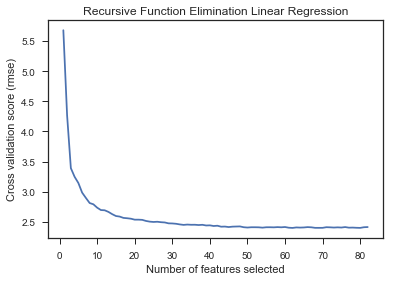

In [158]:
plt.figure()
plt.title('Recursive Function Elimination Linear Regression')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (rmse)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), np.sqrt(np.abs(rfecv.grid_scores_)))
plt.show()

### Nested Cross Validation AdaBoostRegressor Vs Linear Regression
Using nested cross validation the AdaBoostRegressor is compared with the linear regression model. The AdaBoostRegressor wins the lowest RMSE score.

In [52]:
cachedir = mkdtemp()
estimators = [('reg_model', LinearRegression())]
regr_pipe = Pipeline(estimators, memory=cachedir)

In [53]:
adaReg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=13, splitter='random', criterion='mse'
                                                , random_state=rng)
                           , n_estimators=600, loss='linear', learning_rate=1, random_state=rng)

In [54]:
param_grid = dict(reg_model=[rfecv, adaReg])

In [55]:
reg_grid = GridSearchCV(estimator=regr_pipe, param_grid=param_grid, scoring=scoring, cv=inner_cv
                        , error_score=0, refit='mse')
reg_pred = reg_grid.fit(poverty_X, poverty_y)

Pipeline(memory='/var/folders/_j/vyb4dyfx2wq850vj9vh25wy40000gn/T/tmpe8qvy037',
     steps=[('reg_model', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0....oss='linear', n_estimators=600,
         random_state=<mtrand.RandomState object at 0x1a2f38ecf0>))])

In [56]:
train_scores = cross_validate(reg_grid, poverty_X, poverty_y, cv=outer_cv, scoring=scoring, return_train_score=True)
pprint('RMSE score: %f' % np.average(np.sqrt(np.abs(train_scores['test_mse']))))

'RMSE score: 2.428183'


### Recursive Feature Selection AdaBoostRegressor
To improve the AdaBoostRegressor even more, the best features are selected using recursive feature elimination or backwards elimination.

In [57]:
mse = make_scorer(mean_squared_error, greater_is_better=False)

rfecv = RFECV(estimator=adaReg, step=1, cv=inner_cv, scoring=mse)

rfecv.fit(poverty_X, poverty_y)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 62


In [58]:
pprint('RMSE score: %f' % np.sqrt(np.abs(rfecv.grid_scores_[rfecv.n_features_])))

'RMSE score: 2.406639'


In [59]:
train_scores = cross_validate(rfecv, poverty_X, poverty_y, cv=outer_cv, scoring=scoring, return_train_score=True)
pprint('RMSE score: %f' % np.average(np.sqrt(np.abs(train_scores['test_mse']))))

'RMSE score: 2.366428'


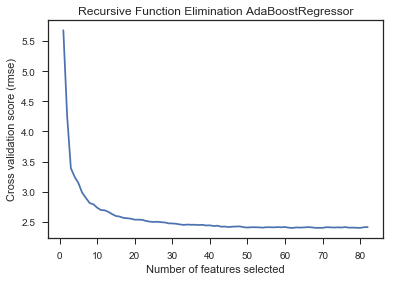

In [60]:
plt.figure()
plt.title('Recursive Function Elimination AdaBoostRegressor')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (rmse)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), np.sqrt(np.abs(rfecv.grid_scores_)))
plt.show()

### Analysis of Predictions and Residuals
The Analysis of the quality of the predictions and residuals shows that the accuracy of the AdaBoostRegressor is  high. However the AdaBoostRegressor probably slightly overfits the data.

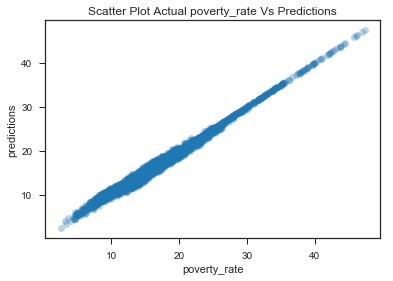

In [159]:
sc1_tmp = sns.regplot(x=poverty_y, y=rfecv.predict(poverty_X), fit_reg=False, color='#1f77b4', scatter_kws={'alpha':0.3})
tmp = sc1_tmp.set_ylabel('predictions')
tmp = sc1_tmp.set_title('Scatter Plot Actual poverty_rate Vs Predictions')

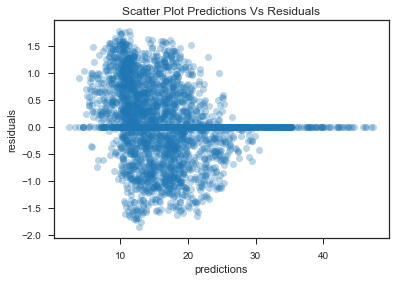

In [160]:
sc2_tmp = sns.regplot(x=rfecv.predict(poverty_X), y=rfecv.predict(poverty_X) - poverty_y
                      , fit_reg=False, color='#1f77b4', scatter_kws={'alpha':0.3})
tmp = sc2_tmp.set_xlabel('predictions')
tmp = sc2_tmp.set_ylabel('residuals')
tmp = sc2_tmp.set_title('Scatter Plot Predictions Vs Residuals')

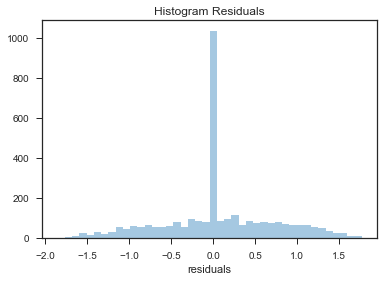

In [161]:
residuals = rfecv.predict(poverty_X) - poverty_y
residuals = residuals.rename('residuals')
ht_pov = sns.distplot(residuals, color='#1f77b4', kde=False).set_title('Histogram Residuals')

In [67]:
poverty_test = pd.read_csv('./Microsoft_-_DAT102x_Predicting_Poverty_in_the_United_States_-_Test_values.csv')

In [68]:
#Create Features
poverty_test = create_old_age_cat(poverty_test)
poverty_test = create_aui_pct65y_cat(poverty_test)
poverty_test = create_features(poverty_test)

#Convert to correct type
poverty_test = convert_to_cat(poverty_test)

#Drop Features
poverty_row_id = poverty_test.row_id
poverty_test = drop_features(poverty_test)
poverty_test = poverty_test.drop(columns=['row_id'], axis=1)

#Replace NANs
poverty_test_clean = poverty_test.fillna(poverty_test.median())
poverty_test_clean = cat_to_dummies(poverty_test_clean)

#Scale Features
poverty_test_clean = scale_features(poverty_test_clean)

In [69]:
#Create Prediction
submission = pd.DataFrame(rfecv.predict(poverty_test_clean))
submission = np.clip(submission,2.50, 48.00)

In [70]:
poverty_submission = pd.concat([poverty_row_id, submission], axis=1)
poverty_submission = poverty_submission.rename(index=str, columns={0: 'poverty_rate'})
poverty_submission = poverty_submission.round({'poverty_rate':2})

In [71]:
poverty_submission.to_csv(path_or_buf='./MV_Poverty_Submission_AdaReg_tmp.csv', index=False)

## Conclusion

The Regression analysis shows that is possible to build an accurate regression model to predict poverty rates of United States' counties using an AdaBoostRegressor. From the data exploration phase it is clear that economical, educational, ethnical and health related factors play an important role in predicting poverty. However is recursive function elemination is used to determine the optimal number of features that leads to the best prediction.